# Import Libraries

In [111]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from imblearn.pipeline import Pipeline
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import RobustScaler,OneHotEncoder


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score,balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics import recall_score, f1_score,roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve,ConfusionMatrixDisplay

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold

import pickle


In [112]:
! pip3 install xgboost

In [113]:
from xgboost import XGBClassifier

In [114]:
! pip3 install lightgbm

In [115]:
from lightgbm import LGBMClassifier

## Generic Functions

In [116]:
def calculate_metrics(y_test, y_pred, model=None, X_test=None):

    metrics = {
        'Accuracy': np.round(accuracy_score(y_test, y_pred),2),
        'Precision':  np.round(precision_score(y_test, y_pred, average='weighted'),2),
        'Recall':  np.round(recall_score(y_test, y_pred, average='weighted'),2),
        'F1 Score':  np.round(f1_score(y_test, y_pred, average='weighted'),2),
        'Balanced Accuracy':  np.round(balanced_accuracy_score(y_test, y_pred),2)
    }

    # ROC AUC Score (if probabilities are available)
    if model is not None and X_test is not None:
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]  # Binary classification
            metrics['ROC AUC'] = np.round(roc_auc_score(y_test, y_proba),2)
        else:
            metrics['ROC AUC'] = 'Not applicable'
    else:
        metrics['ROC AUC'] = 'Not applicable'

    return pd.DataFrame(metrics, index=['Metrics'])

# Loading Dataset

In [117]:
#from google.colab import drive
#drive.mount('/content/drive')

In [118]:
df = pd.read_csv("C:\\Users\\kiran\\OneDrive\\Desktop\\Data Analyst\\ICT- Data Science\\Project\\Dataset\\fraud_0.1origbase.csv")

In [119]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0,0
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0,0
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0,0
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,0,0
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,0,0


# Data Understanding

In [120]:
# Columns
df.columns.tolist()

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

## Column Description

- step: maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- type: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- amount: amount of the transaction in local currency.

- nameOrig: customer who started the transaction

- oldbalanceOrg: initial balance before the transaction

- newbalanceOrig: new balance after the transaction

- nameDest: customer who is the recipient of the transaction

- oldbalanceDest: initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- newbalanceDest: new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

- isFraud: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

- isFlaggedFraud: The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200k in a single transaction.

## Types of Transactions

1) Cash Transactions (CASH-IN, CASH-OUT)
  - A cash transaction is any transaction where money is exchanged for a good, service, or other commodity. Cash transactions can refer to items bought     with physical money, such as coins or cash, or with a debit card. These differ from credit transactions because the money is immediately taken from     the buyer and given to the seller.

- A cash transaction stands in contrast to other modes of payment, such as credit transactions in a business involving bills receivable. Similarly, a cash transaction is also different from credit card transactions.

2) Transfer
- A transfer is the movement of assets, funds, or ownership rights from one place to another. Is also used to describe the process by which ownership of funds or assets are reassigned to a new owner. Banking, brokerage, cryptocurrency, asset titles, and loan transfers are a few examples of domains and transaction types where transfers occur.

3) Debit
- A debit card payment is the same as an immediate payment of cash as the amount gets instantly debited from your bank account.

- Debit cards allow bank customers to spend money by drawing on existing funds they have already deposited at the bank, such as from a checking account. A debit transaction using your PIN (personal identification number), is an online transaction completed in real time. When you complete a debit transaction, you authorize the purchase with your PIN and the merchant communicates immediately with your bank or credit union, causing the funds to be transferred in real time.

- In a credit card payment made by you, the amount is not debited from your bank account instantly. However, you are able to buy the product within your credit limit under the credit card. You need to make payment only after the generation of your credit card bill

4) Payment
- An act initiated by the payer or payee, or on behalf of the payer, of placing, transferring or withdrawing funds, irrespective of any underlying obligations between the payer and payee.

## Shape of Dataset

In [121]:

print("No.of rows:", df.shape[0])
print("No.of columns:", df.shape[1])

No.of rows: 636262
No.of columns: 11


## Size of Dataset

In [122]:
print("Size of dataset:",df.size)

Size of dataset: 6998882


## Identifying data types

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636262 entries, 0 to 636261
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            636262 non-null  int64  
 1   type            636262 non-null  object 
 2   amount          636262 non-null  float64
 3   nameOrig        636262 non-null  object 
 4   oldbalanceOrg   636262 non-null  float64
 5   newbalanceOrig  636262 non-null  float64
 6   nameDest        636262 non-null  object 
 7   oldbalanceDest  636262 non-null  float64
 8   newbalanceDest  636262 non-null  float64
 9   isFraud         636262 non-null  int64  
 10  isFlaggedFraud  636262 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 53.4+ MB


## Statistical Features

In [124]:
df1 = df.copy()


In [125]:
# Changing data type for easier analysis
df1['isFraud'] = df1['isFraud'].map({1: 'yes', 0: 'no'})
df1['isFlaggedFraud'] = df1['isFlaggedFraud'].map({1: 'yes', 0: 'no'})

In [126]:
# Splitting Into numerical and categorical variables for easy analysis
num_attributes = df1.select_dtypes(exclude='object')
cat_attributes = df1.select_dtypes(include='object')

In [127]:
# Statistical Features of Numerical Columns
describe = num_attributes.describe().T
describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()
describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
step,636262.0,2.429319e+02,1.423309e+02,1.0,155.000,238.000,3.340000e+02,7.420000e+02,7.410000e+02,0.585888,0.375052,0.324437
amount,636262.0,1.800585e+05,6.069714e+05,0.0,13407.425,74815.770,2.084988e+05,5.722962e+07,5.722962e+07,3.370967,29.577107,1546.661043
oldbalanceOrg,636262.0,8.317937e+05,2.885636e+06,0.0,0.000,14239.000,1.072998e+05,4.368662e+07,4.368662e+07,3.469173,5.243428,32.766036
newbalanceOrig,636262.0,8.528354e+05,2.921296e+06,0.0,0.000,0.000,1.435652e+05,4.367380e+07,4.367380e+07,3.425393,5.173614,31.932547
oldbalanceDest,636262.0,1.096212e+06,3.375389e+06,0.0,0.000,131539.745,9.384820e+05,3.551855e+08,3.551855e+08,3.079138,20.622388,1074.335293
newbalanceDest,636262.0,1.221809e+06,3.656213e+06,0.0,0.000,214712.725,1.109230e+06,3.555534e+08,3.555534e+08,2.992460,19.623903,928.694204


### Insights from descriptive statistics for numerical columns

- Most variables exhibit significant skewness and kurtosis, indicating the presence of outliers and heavy-tailed distributions.
- The wide ranges and high variation coefficients for financial variables ("Amount," "OldbalanceOrg," etc.) suggest the need for scaling or normalization before analysis.
- The nearly symmetric distribution of "Step" makes it suitable for straightforward statistical methods.

In [128]:
## Statistical Features of Categorical Columns
cat_attributes.describe().T

,count,unique,top,freq
type,636262,5,CASH_OUT,224216
nameOrig,636262,636171,C334643493,2
nameDest,636262,457224,C2083562754,14
isFraud,636262,2,no,635441
isFlaggedFraud,636262,2,no,636260


### Insights from statistical features for categorical columns

- Type: The dominance of "CASH_OUT" suggests it may warrant closer inspection, especially for fraud patterns.
- nameOrig/nameDest: Significant duplication in destination accounts (nameDest) might indicate repeated fraudulent activity or common endpoints for legitimate transactions.
- isFraud: The dataset is heavily imbalanced, with fraudulent transactions comprising only a tiny fraction of the data.
- isFlaggedFraud: Almost no transactions are flagged, raising questions about the criteria for flagging.

# 

Checking for missing values

In [129]:
print("Sum of null values in each column :\n",df.isna().sum())

Sum of null values in each column :
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


<Axes: >

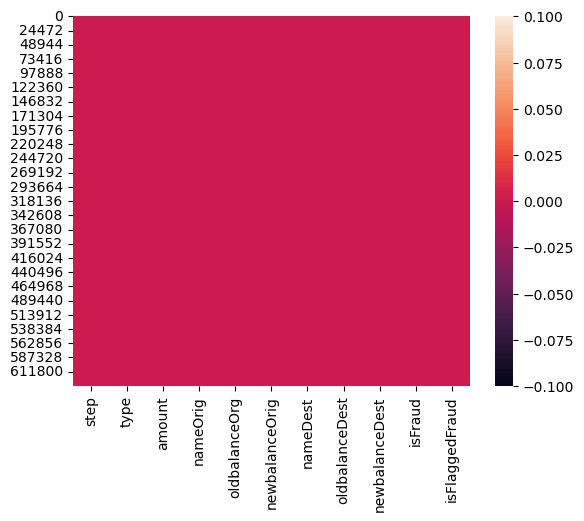

In [130]:
sns.heatmap(df.isna())

- No missing values found in the dataset

# Dropping Unecessay columns

In [131]:
trans_flaged = df1.loc[df1['isFlaggedFraud'] =='yes']
trans_flaged

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
386601,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,yes,yes
566452,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,yes,yes


In [132]:
print("Number of transactions above 200k flagged as fraud is  {}".format(trans_flaged.shape[0]))

Number of transactions above 200k flagged as fraud is  2


In [133]:
trans_200k = df1.loc[df1['amount'] > 200000].shape[0]
print("Number of transactions above 200k is {}".format(trans_200k))

Number of transactions above 200k is 167033


In [134]:
df = df.drop('isFlaggedFraud',axis=1)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,0
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,0


- The isFlaggedFraud column is dropped.
- The column is meant to flag all suspicious transactions having amount above 200k.
- But the flag is true for only two columns even when there is 167033 transaction with amount above 200k.

# Duplicate Rows

In [135]:
print("Total duplicate rows:", df.duplicated().sum())

Total duplicate rows: 0



- No duplicates found in the dataset

# Feature Engineering

In [136]:

df2 = df1.copy()

In [137]:
# step
df2['step_days'] = df2['step'].apply(lambda i: i/24).astype(int)

# difference between initial balance before the transaction and new balance after the transaction
df2['diff_new_old_orgin'] = df2['newbalanceOrig'] - df2['oldbalanceOrg']

# difference between initial balance recipient before the transaction and new balance recipient after the transaction.
df2['diff_new_old_dest'] = df2['newbalanceDest'] - df2['oldbalanceDest']

# name orig and name dest
df2['nameOrig'] = df2['nameOrig'].apply(lambda i: i[0])
df2['nameDest'] = df2['nameDest'].apply(lambda i: i[0])

In [138]:
df2

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,step_days,diff_new_old_orgin,diff_new_old_dest
0,283,CASH_IN,210329.84,C,3778062.79,3988392.64,C,1519266.60,1308936.76,no,no,11,210329.85,-210329.84
1,132,CASH_OUT,215489.19,C,21518.00,0.00,C,6345756.55,6794954.89,no,no,5,-21518.00,449198.34
2,355,DEBIT,4431.05,C,20674.00,16242.95,C,80876.56,85307.61,no,no,14,-4431.05,4431.05
3,135,CASH_OUT,214026.20,C,46909.73,0.00,C,13467450.36,13681476.56,no,no,5,-46909.73,214026.20
4,381,CASH_OUT,8858.45,C,0.00,0.00,C,1667180.58,1676039.03,no,no,15,0.00,8858.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636257,351,CASH_OUT,28761.10,C,0.00,0.00,C,328534.52,357295.62,no,no,14,0.00,28761.10
636258,184,CASH_OUT,167820.71,C,62265.00,0.00,C,106429.48,274250.18,no,no,7,-62265.00,167820.70
636259,35,PAYMENT,8898.12,C,30808.00,21909.88,M,0.00,0.00,no,no,1,-8898.12,0.00
636260,277,CASH_OUT,176147.90,C,83669.00,0.00,C,0.00,176147.90,no,no,11,-83669.00,176147.90


# Exploratory Data Analysis (EDA)

## Univariate Analysis

### Numerical Variables

In [139]:
# List of numerical columns
numerical_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest','step_days',
                     'diff_new_old_orgin','diff_new_old_dest']
# List of categorical columns
categorical_columns = ['type','isFraud','nameDest','nameOrig']

In [140]:
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")

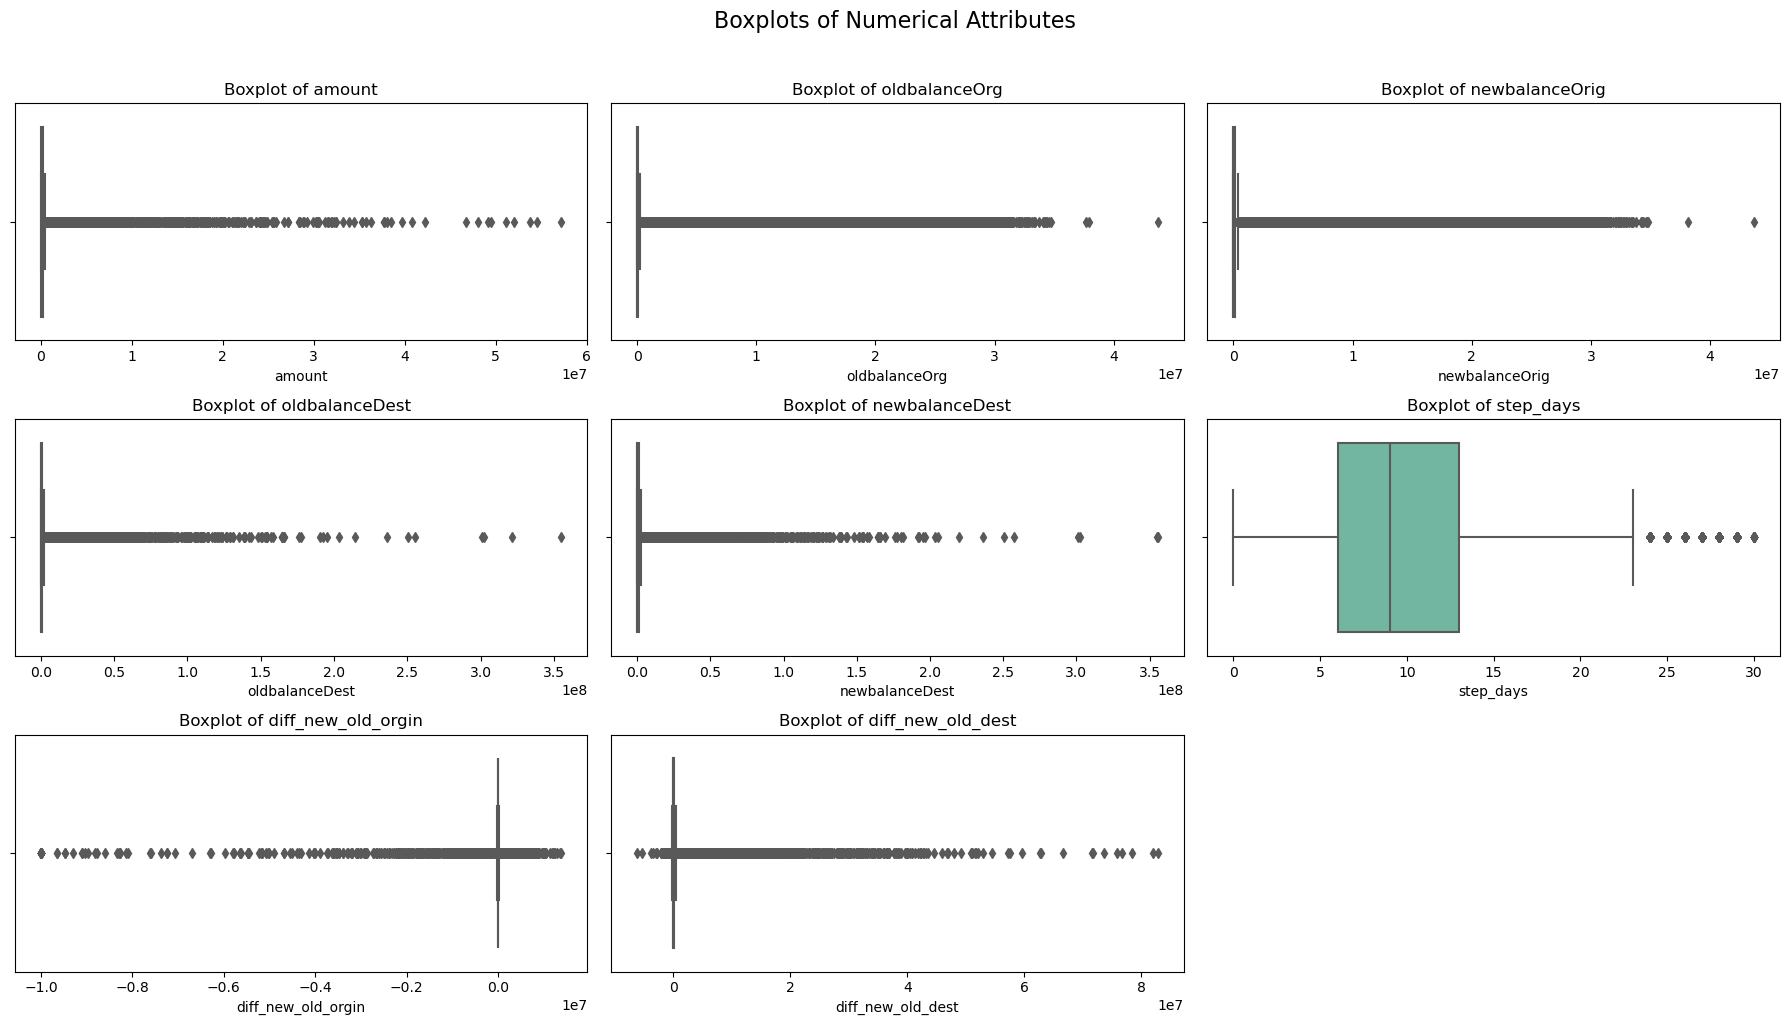

In [141]:
# Boxplots
plt.figure(figsize=(18, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)  # 2 rows, 3 columns
    sns.boxplot(x=df2[column], palette='Set2')
    plt.title(f"Boxplot of {column}")
    plt.xlabel(column)

plt.suptitle("Boxplots of Numerical Attributes", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


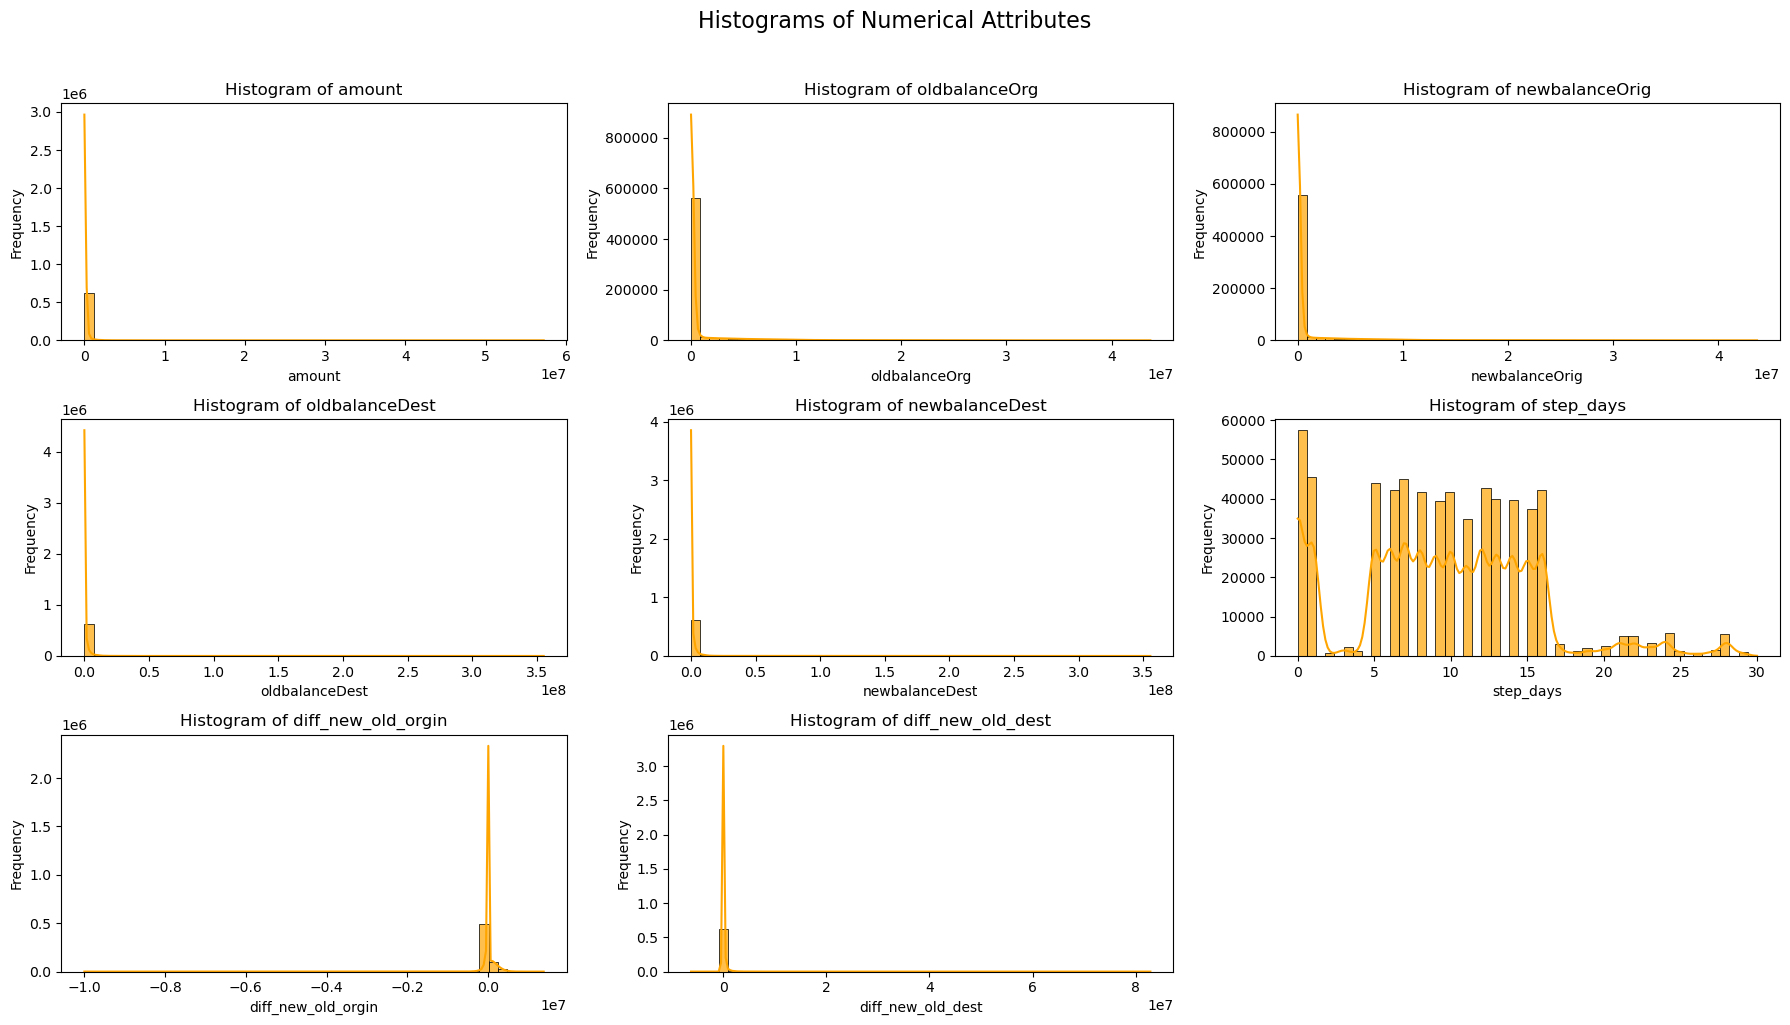

In [142]:
# Histograms
plt.figure(figsize=(18, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)  # 2 rows, 3 columns
    sns.histplot(df2[column], kde=True, bins=50, color='orange', alpha=0.7)
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

plt.suptitle("Histograms of Numerical Attributes", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Categorical variables

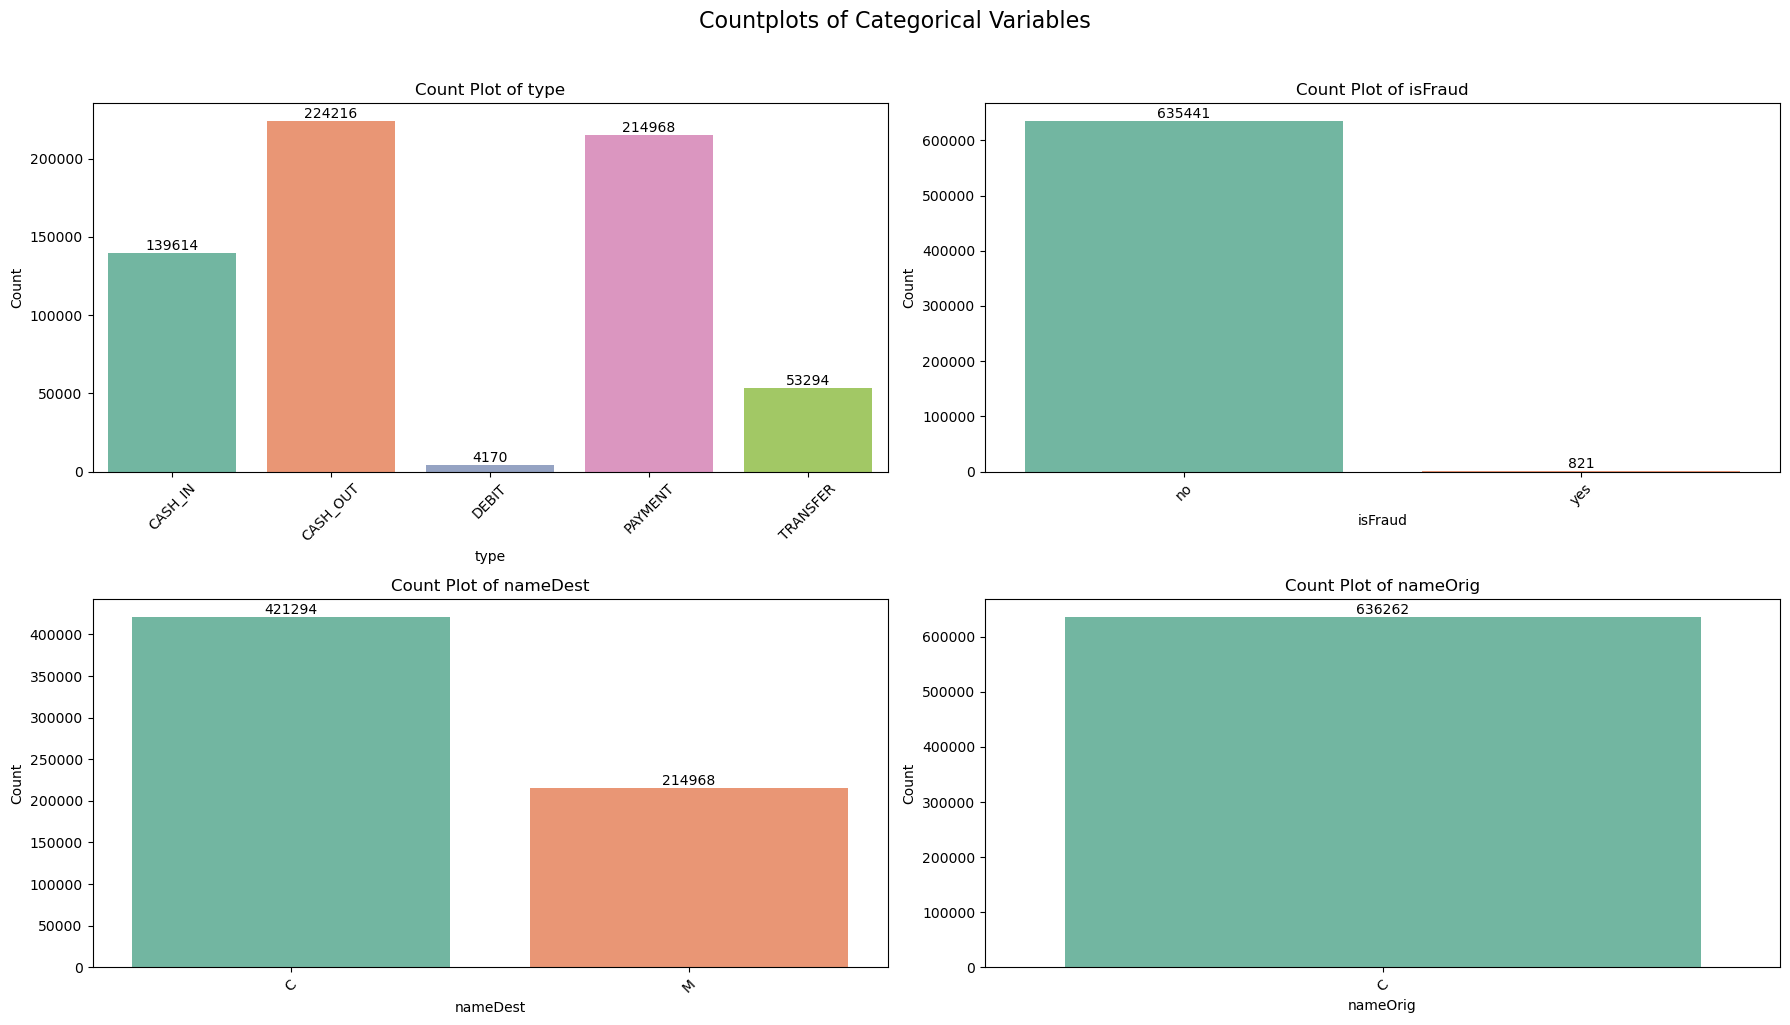

In [143]:
# count plot
plt.figure(figsize=(18, 10))
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(2, 2, i)  # 2 rows, 2 columns
    ax = sns.countplot(data=df2, x=df2[column], palette='Set2')

    for bars in ax.containers:
        ax.bar_label(bars, fmt='%.0f')

    plt.title(f"Count Plot of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

plt.suptitle("Countplots of Categorical Variables", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## Bivariate Analysis

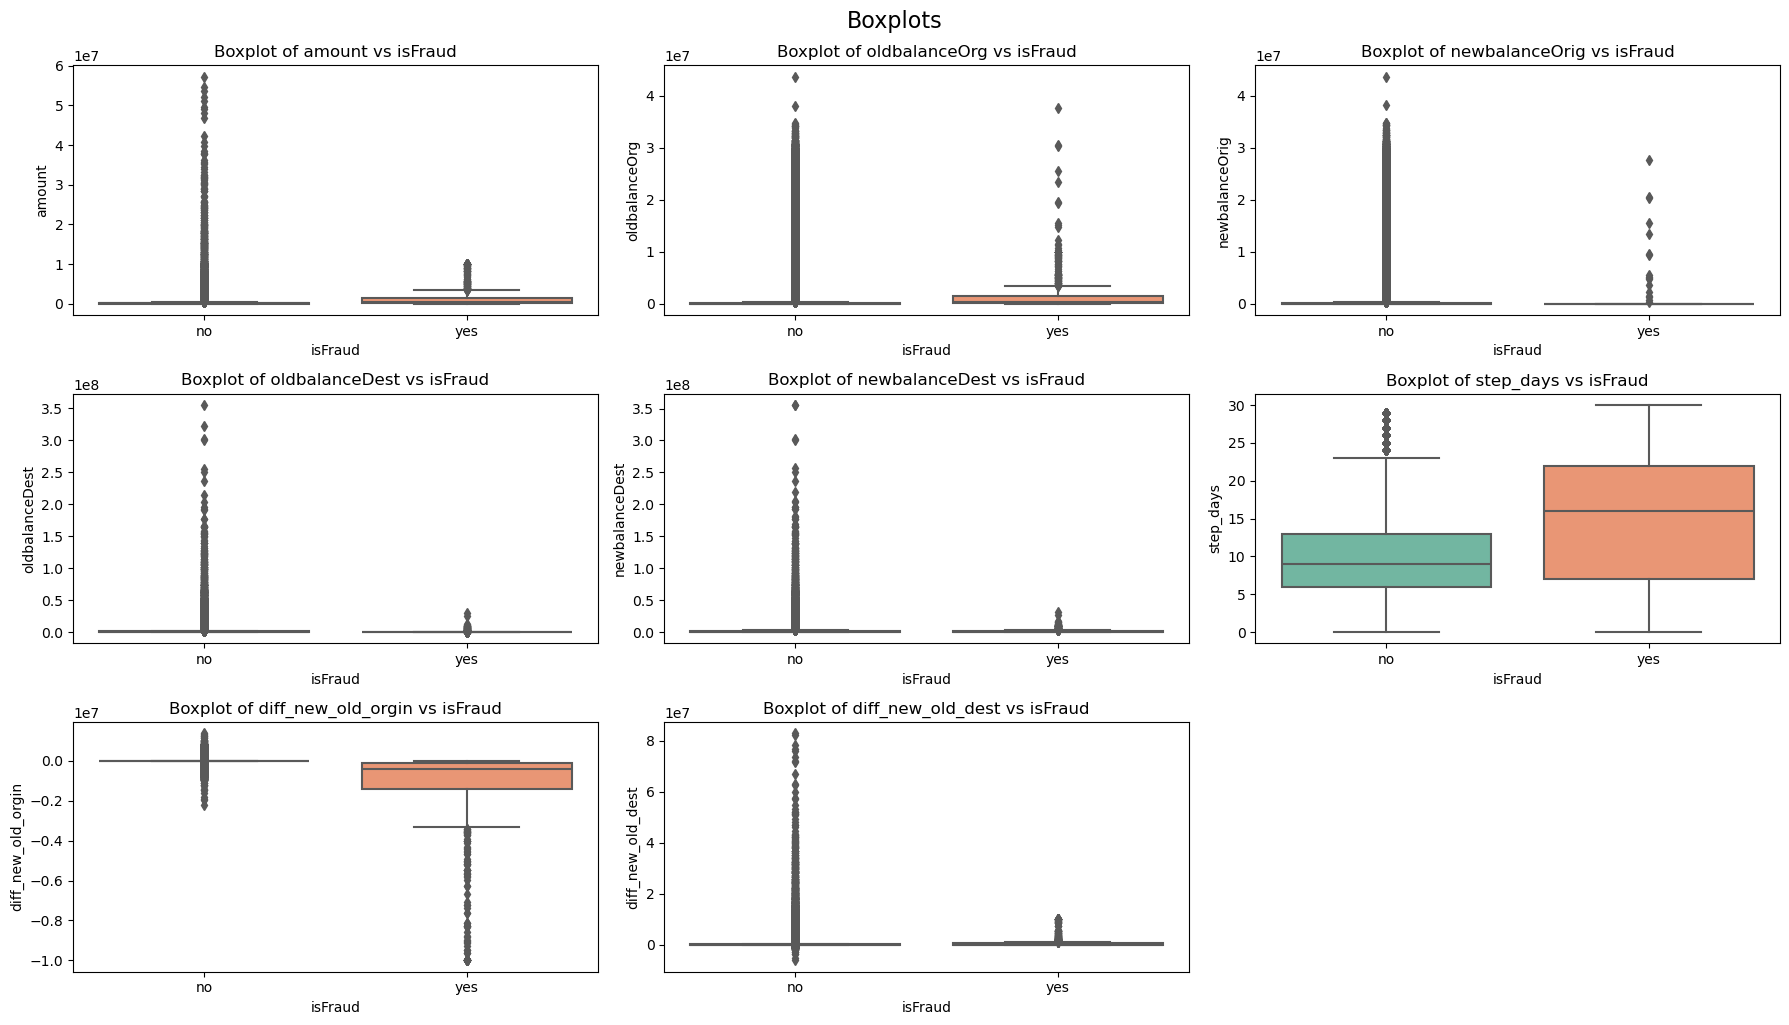

In [144]:
# Numerical vs. Categorical: Boxplots for each numerical variable against a categorical variable
plt.figure(figsize=(18, 10))
for i, column in enumerate(numerical_columns[:8], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df2, x='isFraud', y=column, palette='Set2')
    plt.title(f"Boxplot of {column} vs isFraud")
    plt.xlabel('isFraud')
    plt.ylabel(column)
    plt.tight_layout()

plt.suptitle("Boxplots", fontsize=16, y=1.02)
plt.show()


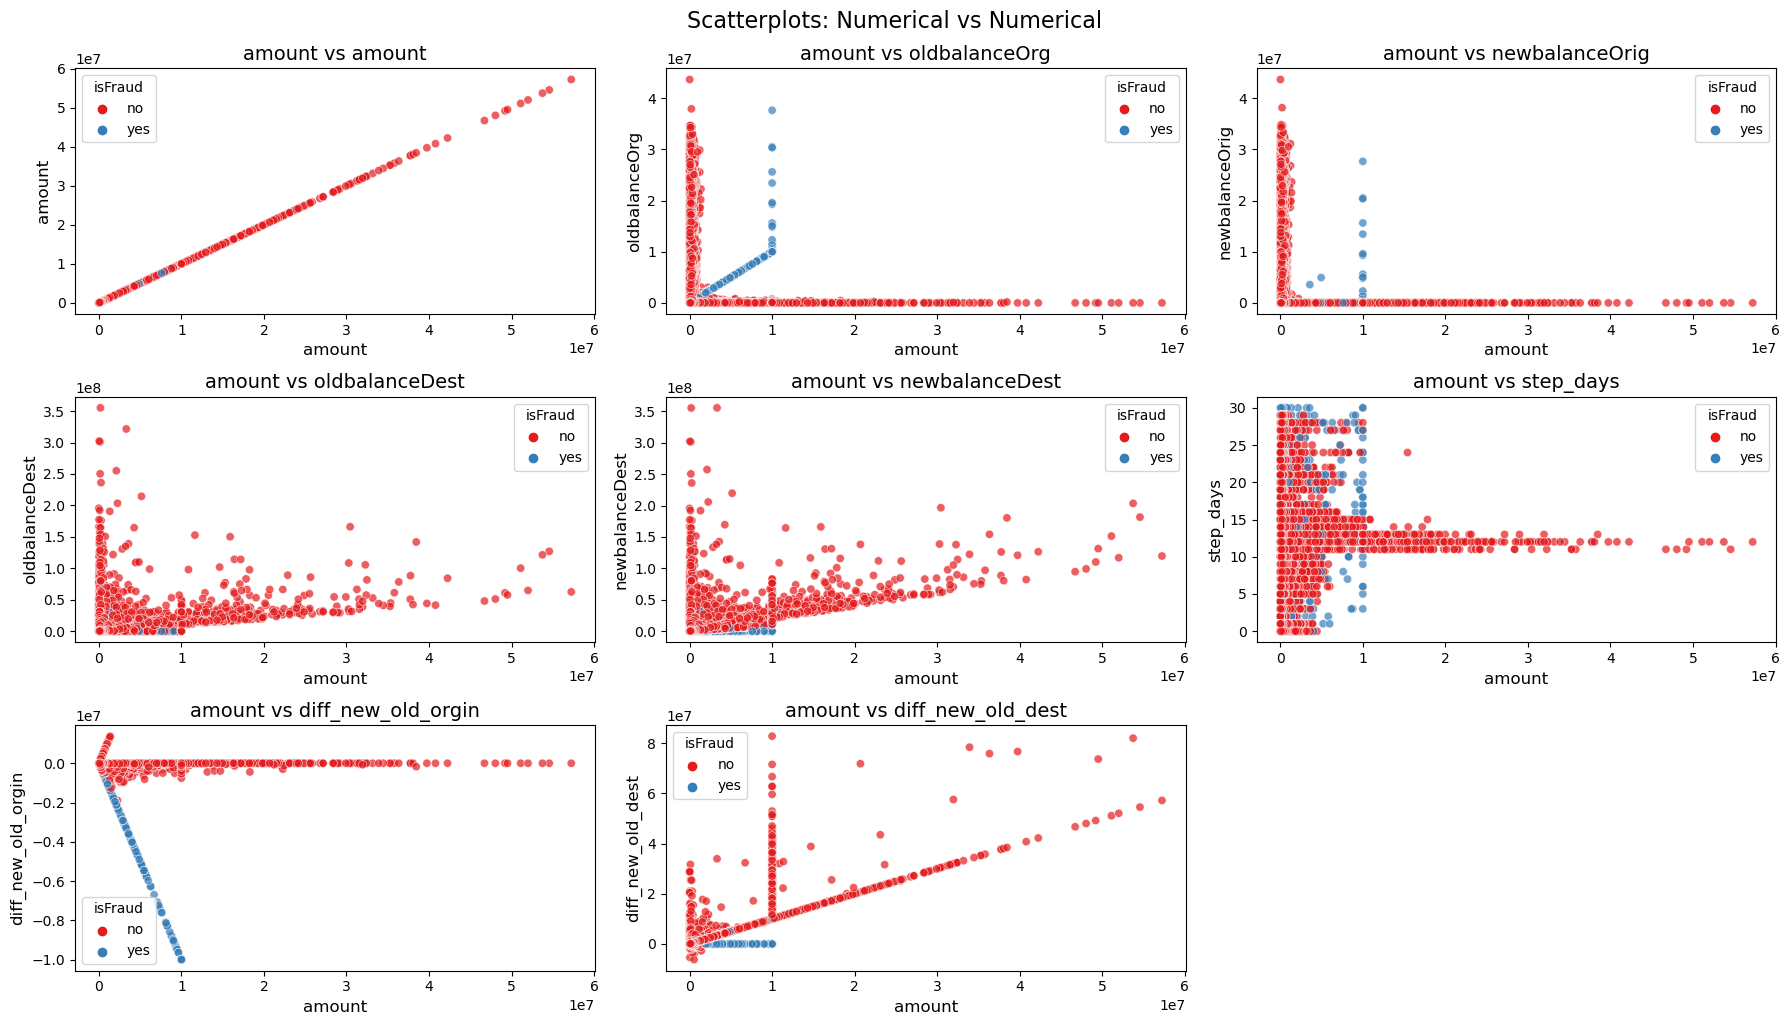

In [145]:
plt.figure(figsize=(18, 10) )
for i, num_col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(data=df2, x='amount', y=num_col, hue='isFraud', palette='Set1', alpha=0.7)
    plt.title(f"amount vs {num_col}", fontsize=14)
    plt.xlabel("amount", fontsize=12)
    plt.ylabel(num_col, fontsize=12)
    plt.tight_layout()

plt.suptitle("Scatterplots: Numerical vs Numerical", fontsize=16, y=1.02)
plt.show()

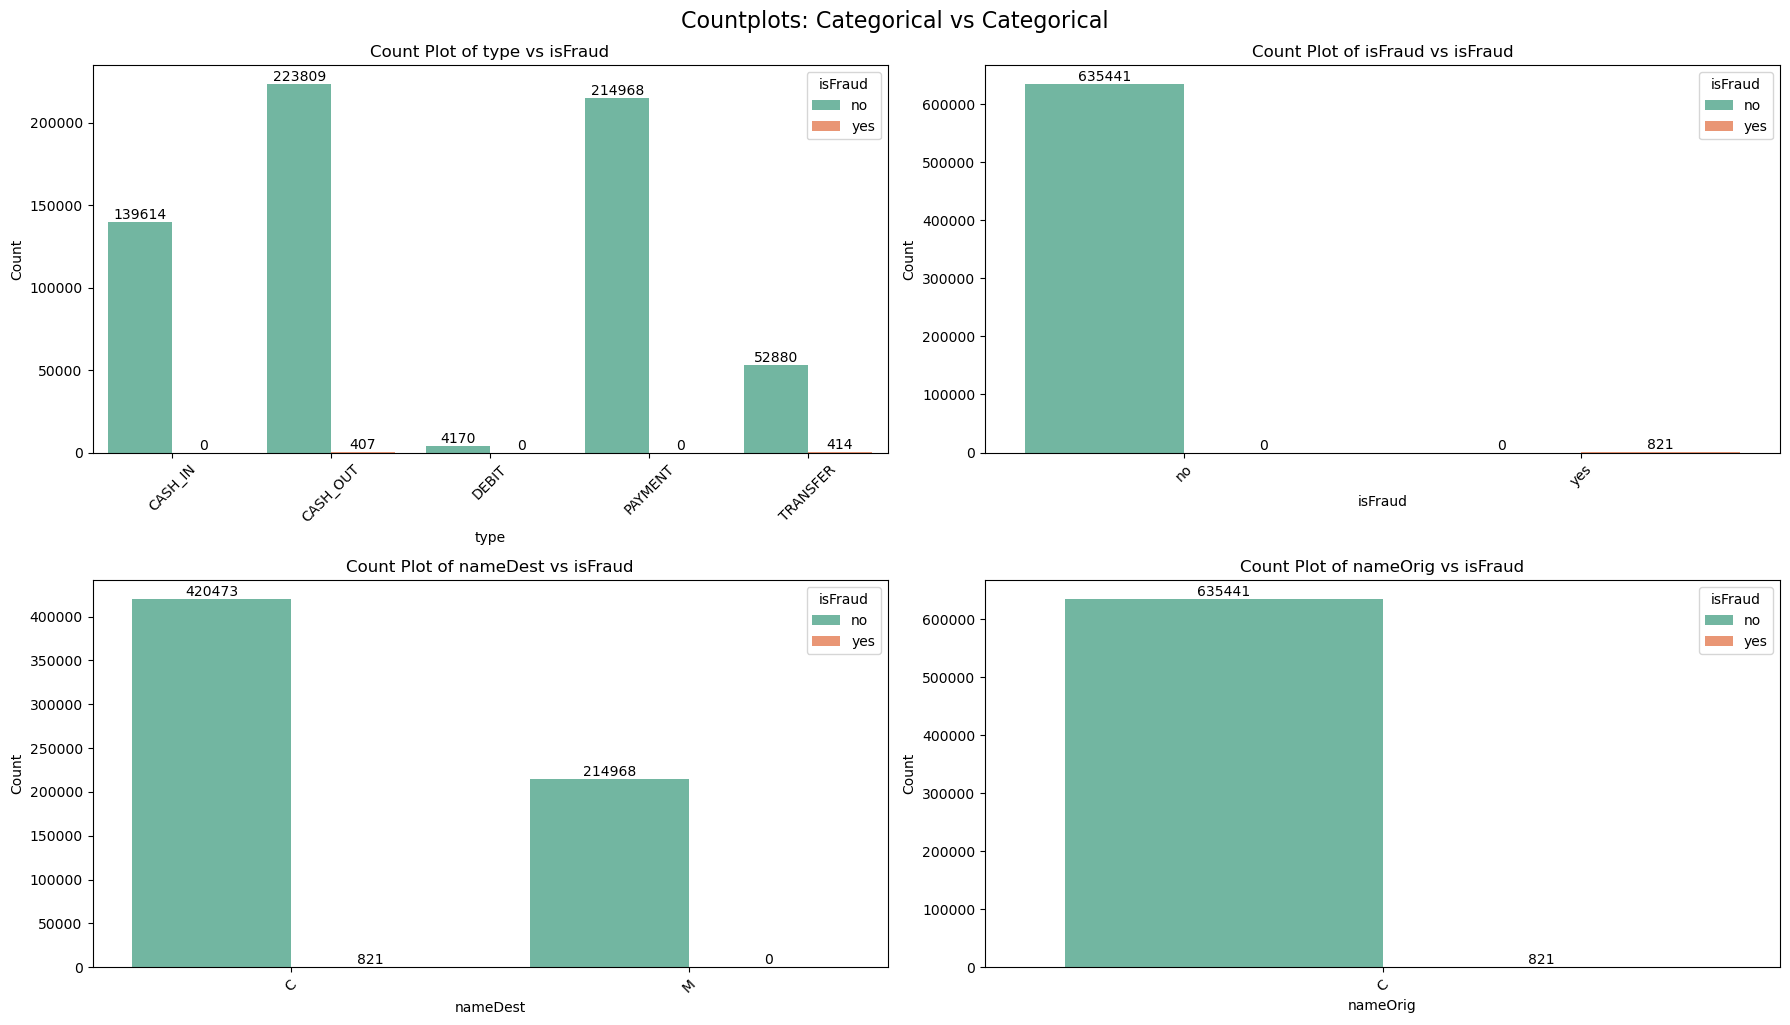

In [146]:
plt.figure(figsize=(18, 10))

for i, column in enumerate(categorical_columns, 1):
    plt.subplot(2, 2, i)


    ax = sns.countplot(data=df2, x=column, hue='isFraud', palette='Set2')


    for bars in ax.containers:
        ax.bar_label(bars, fmt='%.0f')


    plt.title(f"Count Plot of {column} vs isFraud")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.legend(title="isFraud")
    plt.tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.suptitle("Countplots: Categorical vs Categorical", fontsize=16, y=1.02)
plt.show()


## Multivariate Analysis

In [147]:
df_corr = df2.copy()

<Axes: >

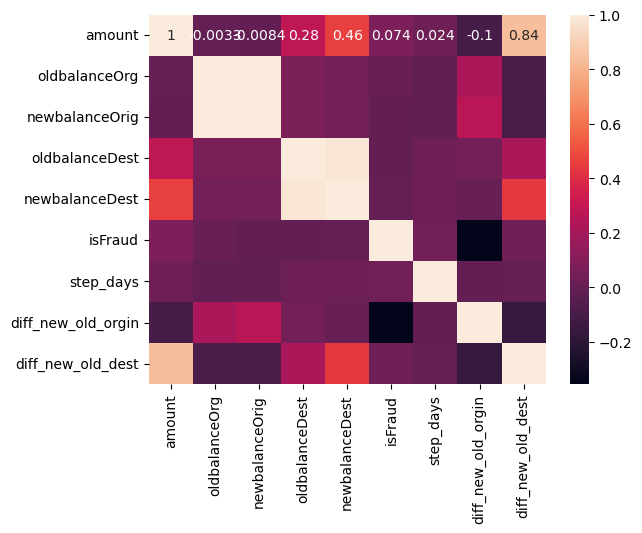

In [148]:

# Changing data type for easier analysis
df_corr['isFraud'] = df_corr['isFraud'].map({'yes':1, 'no':0})
df_corr = df_corr.drop('step',axis =1)

num_attributes2 = df_corr.select_dtypes(exclude='object')
corr = num_attributes2.corr()
sns.heatmap(corr, annot=True)

# Feature Encoding

In [149]:
df3 = df2.copy()

In [150]:
df3 = df3.drop(["step",'nameOrig','nameDest','isFlaggedFraud'],axis = 1)

In [151]:
# Onehot Encoding
one_hot_enc = OneHotEncoder(sparse_output=False)
one = one_hot_enc.fit_transform(df3[['type']])
one

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [152]:
one1 = pd.DataFrame(one,columns= ["type_CASH_IN","type_CASH_OUT","type_DEBIT","type_PAYMENT","type_TRANSFER"])
one1

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
636257,0.0,1.0,0.0,0.0,0.0
636258,0.0,1.0,0.0,0.0,0.0
636259,0.0,0.0,0.0,1.0,0.0
636260,0.0,1.0,0.0,0.0,0.0


In [153]:
df3 = pd.concat([df3,one1],axis=1)
df3.head(3)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,step_days,diff_new_old_orgin,diff_new_old_dest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,CASH_IN,210329.84,3778062.79,3988392.64,1519266.60,1308936.76,no,11,210329.85,-210329.84,1.0,0.0,0.0,0.0,0.0
1,CASH_OUT,215489.19,21518.00,0.00,6345756.55,6794954.89,no,5,-21518.00,449198.34,0.0,1.0,0.0,0.0,0.0
2,DEBIT,4431.05,20674.00,16242.95,80876.56,85307.61,no,14,-4431.05,4431.05,0.0,0.0,1.0,0.0,0.0


In [154]:
df3 = df3.drop(['type'],axis=1)


In [155]:
df3['isFraud'] = df3['isFraud'].map({'no': 0, 'yes': 1})
df3.head(3)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,step_days,diff_new_old_orgin,diff_new_old_dest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,210329.84,3778062.79,3988392.64,1519266.60,1308936.76,0,11,210329.85,-210329.84,1.0,0.0,0.0,0.0,0.0
1,215489.19,21518.00,0.00,6345756.55,6794954.89,0,5,-21518.00,449198.34,0.0,1.0,0.0,0.0,0.0
2,4431.05,20674.00,16242.95,80876.56,85307.61,0,14,-4431.05,4431.05,0.0,0.0,1.0,0.0,0.0


# Handling Imbalace in Taget Column

## Checking for class imbalance

In [156]:
Target_class = df1["isFraud"].value_counts()
Target_class

isFraud
no     635441
yes       821
Name: count, dtype: int64

In [157]:
Target_class = df1["isFraud"].value_counts()/len(df1) * 100
print("Percentage of non fraud and fraud transactions respectively in target column is {}".format(Target_class))

Percentage of non fraud and fraud transactions respectively in target column is isFraud
no     99.870965
yes     0.129035
Name: count, dtype: float64


## Upsampling minority class in target column using SMOTE & downsampling majority class in target column simultaneously.

In [158]:
# Separate features and target
X = df3.drop('isFraud', axis=1)
y = df3['isFraud']

In [159]:
# Step 1: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Before resampling:")
print("Training class distribution:", Counter(y_train))
print("Testing class distribution:", Counter(y_test))

Before resampling:
Training class distribution: Counter({0: 444808, 1: 575})
Testing class distribution: Counter({0: 190633, 1: 246})


In [160]:
# Step 2: Define the sampling strategies
oversample = SMOTE(sampling_strategy='minority', random_state=42)
undersample = RandomUnderSampler(sampling_strategy={0: 100000, 1: 100000}, random_state=42)

In [161]:
# Step 3: Create a pipeline that first oversamples and then undersamples
pipeline = Pipeline(steps=[('o', oversample), ('u', undersample)])

In [162]:
# Step 4: Fit and transform only the training data
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

print("After resampling:")
print("Resampled training class distribution:", Counter(y_train_resampled))

After resampling:
Resampled training class distribution: Counter({0: 100000, 1: 100000})


In [163]:
# Step 5: Combine back into a DataFrame
balanced_df = pd.DataFrame(X_train_resampled, columns=X_train.columns)
balanced_df['isFraud'] = y_train_resampled

In [164]:
# The test set remains unchanged
print("Testing class distribution remains the same:", Counter(y_test))

Testing class distribution remains the same: Counter({0: 190633, 1: 246})


In [165]:
# Check the class distribution
print(balanced_df['isFraud'].value_counts())

isFraud
0    100000
1    100000
Name: count, dtype: int64


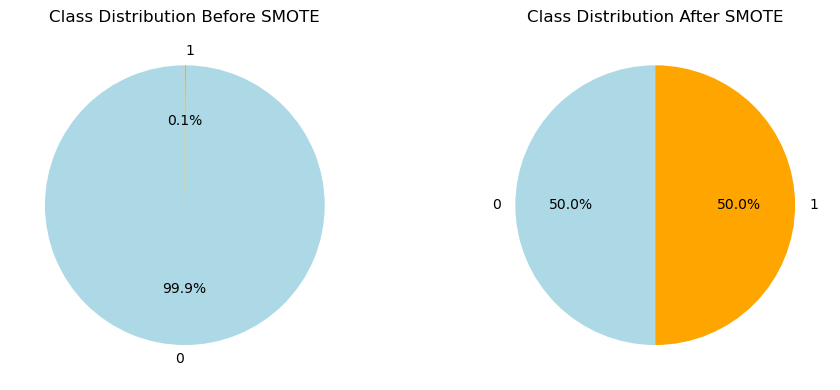

In [166]:
class_counts_before = y_train.value_counts()
class_counts_after = pd.Series(y_train_resampled).value_counts()

# pie charts
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

# Before SMOTE
axes[0].pie(
    class_counts_before,
    labels=class_counts_before.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightblue', 'orange']
)
axes[0].set_title("Class Distribution Before SMOTE")

# After SMOTE
axes[1].pie(
    class_counts_after,
    labels=class_counts_after.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightblue', 'orange']
)
axes[1].set_title("Class Distribution After SMOTE")

plt.tight_layout()
plt.show()

## Save Resampled Data

In [167]:
# Save the resampled training data to CSV
balanced_df.to_csv('C:\\Users\\kiran\\OneDrive\\Desktop\\Data Analyst\\ICT- Data Science\\Project\\Dataset\\resampled_training_data.csv', index=False)

# Save the original test set to CSV
X_test_with_target = X_test.copy()
X_test_with_target['isFraud'] = y_test
X_test_with_target.to_csv('C:\\Users\\kiran\\OneDrive\\Desktop\\Data Analyst\\ICT- Data Science\\Project\\Dataset\\test_data.csv', index=False)

print("Resampled training data and test data have been saved.")

Resampled training data and test data have been saved.


In [168]:
## Handling Imbalance using SMOTE (Synthetic Minority Oversampling Technique)

In [169]:
#X = df3.drop('isFraud',axis= 1)
#y = df3["isFraud"]

In [170]:
# Performing train test split before oversampling to avoid data leakage
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [171]:
#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after resampling
#print("Class distribution before SMOTE:", y_train.value_counts())
#print("Class distribution after SMOTE:", pd.Series(y_train_resampled).value_counts())


In [172]:
# class_counts_before = y_train.value_counts()
# class_counts_after = pd.Series(y_train_resampled).value_counts()

# # pie charts
# fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

# # Before SMOTE
# axes[0].pie(
#     class_counts_before,
#     labels=class_counts_before.index,
#     autopct='%1.1f%%',
#     startangle=90,
#     colors=['lightblue', 'orange']
# )
# axes[0].set_title("Class Distribution Before SMOTE")

# # After SMOTE
# axes[1].pie(
#     class_counts_after,
#     labels=class_counts_after.index,
#     autopct='%1.1f%%',
#     startangle=90,
#     colors=['lightblue', 'orange']
# )
# axes[1].set_title("Class Distribution After SMOTE")

# plt.tight_layout()
# plt.show()

In [173]:
# y_test.value_counts()

# Feature Scaling

In [174]:
test_df = pd.read_csv('C:\\Users\\kiran\\OneDrive\\Desktop\\Data Analyst\\ICT- Data Science\\Project\\Dataset\\test_data.csv')

In [175]:
train_df = pd.read_csv('C:\\Users\\kiran\\OneDrive\\Desktop\\Data Analyst\\ICT- Data Science\\Project\\Dataset\\resampled_training_data.csv')

In [176]:
X_train = train_df.iloc[0:,0:13]
y_train = train_df.iloc[0:,-1:]

In [177]:
X_test = test_df.iloc[0:,0:13]
y_test = test_df.iloc[0:,-1:]

In [178]:
test_df[test_df['isFraud']==1]

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,step_days,diff_new_old_orgin,diff_new_old_dest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
380,2561698.04,2561698.04,0.0,93471.68,2655169.72,23,-2561698.04,2561698.04,0.0,1.0,0.0,0.0,0.0,1
761,112363.33,112363.33,0.0,295341.76,407705.09,25,-112363.33,112363.33,0.0,1.0,0.0,0.0,0.0,1
1627,2905831.61,2905831.61,0.0,0.00,0.00,23,-2905831.61,0.00,0.0,0.0,0.0,0.0,1.0,1
1675,225923.37,225923.37,0.0,3140128.43,3366051.80,9,-225923.37,225923.37,0.0,1.0,0.0,0.0,0.0,1
2493,2598276.05,2598276.05,0.0,0.00,0.00,6,-2598276.05,0.00,0.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187787,171456.83,171456.83,0.0,546812.73,718269.56,6,-171456.83,171456.83,0.0,1.0,0.0,0.0,0.0,1
188605,351332.16,351332.16,0.0,0.00,0.00,7,-351332.16,0.00,0.0,0.0,0.0,0.0,1.0,1
189558,927620.44,927620.44,0.0,0.00,0.00,8,-927620.44,0.00,0.0,0.0,0.0,0.0,1.0,1
189984,188473.09,188473.09,0.0,209686.58,398159.67,8,-188473.09,188473.09,0.0,1.0,0.0,0.0,0.0,1


In [179]:
col = X_train.columns.tolist()

In [180]:
scaler = RobustScaler()
scaled_data = scaler.fit_transform(X_train)

scaled_df = pd.DataFrame(scaled_data, columns= col)
scaled_df.head(3)


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,step_days,diff_new_old_orgin,diff_new_old_dest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0.030119,-0.163732,182707.98,2.082665,0.642085,0.888889,0.561539,-0.773205,1.0,0.0,0.0,0.0,0.0
1,-0.346612,-0.164916,0.00,0.000000,-0.118829,-0.444444,0.095026,0.000000,0.0,0.0,0.0,1.0,0.0
2,-0.348585,-0.164916,0.00,0.000000,-0.118829,0.000000,0.095026,0.000000,0.0,0.0,0.0,1.0,0.0


In [181]:
scaled_data_test = scaler.fit_transform(X_test)

scaled_df_test = pd.DataFrame(scaled_data_test, columns= col)
scaled_df_test.head(3)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,step_days,diff_new_old_orgin,diff_new_old_dest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-0.368325,0.057547,0.124763,-0.139064,-0.194345,-0.571429,-0.266059,0.000000,0.0,0.0,0.0,1.0,0.0
1,0.803241,0.147683,0.000000,-0.102673,0.045867,1.000000,-2.942439,1.547334,0.0,1.0,0.0,0.0,0.0
2,2.492135,-0.132565,0.000000,4.329391,4.106556,1.000000,0.000000,3.751761,0.0,0.0,0.0,0.0,1.0


In [182]:
X_resampled = scaled_df
X_test = scaled_df_test

# Model Training

## Logistic Regression

In [183]:
Lr_model = LogisticRegression(random_state=42)
Lr_model.fit(X_resampled, y_train)

C:\Users\kiran\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=42)

In [184]:
# Validation
y_valid_lr = Lr_model.predict(X_resampled)

In [185]:
metrics_df = calculate_metrics(y_train, y_valid_lr, model=Lr_model, X_test=X_resampled)
metrics_df

,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,ROC AUC
Metrics,0.86,0.87,0.86,0.86,0.86,0.92


In [186]:
# Testing on unseen data
y_pred_lr = Lr_model.predict(X_test)

In [187]:
metrics_df = calculate_metrics(y_test, y_pred_lr, model=Lr_model, X_test=X_test)
metrics_df

,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,ROC AUC
Metrics,0.46,1.0,0.46,0.63,0.72,0.93


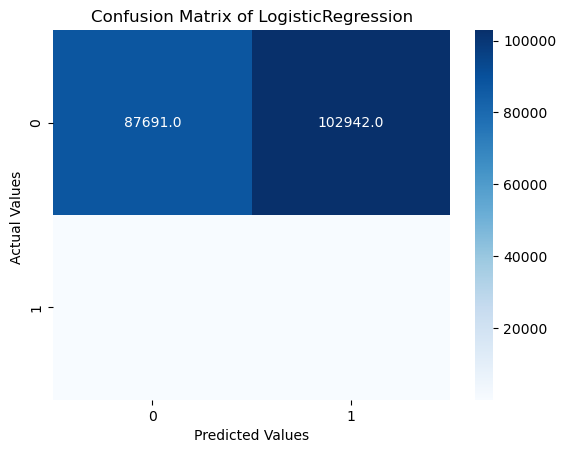

In [188]:
cm_lr = confusion_matrix(y_test, y_pred_lr)                      #------>Confusion Matrix
ax = sns.heatmap(cm_lr, annot=True, cmap='Blues',fmt=".1f")     #------> Heatmap
ax.set_title('Confusion Matrix of LogisticRegression')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

## KNNClassifier

In [189]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_resampled, y_train_resampled)

TypeError: KNeighborsClassifier.__init__() got an unexpected keyword argument 'random_state'

In [ ]:
# Validation
y_valid_knn = knn_model.predict(X_resampled)

In [ ]:
metrics_df = calculate_metrics(y_train_resampled, y_valid_knn, model=knn_model, X_test=X_resampled)
metrics_df

In [ ]:
# Testing on validation data
y_pred_knn = knn_model.predict(X_test)

In [ ]:
metrics_df = calculate_metrics(y_test, y_pred_knn, model=knn_model, X_test=X_test)
metrics_df

In [ ]:
cm_knn = confusion_matrix(y_test, y_pred_knn)                      #------>Confusion Matrix
ax = sns.heatmap(cm_knn, annot=True, cmap='Blues',fmt=".1f")     #------> Heatmap
ax.set_title('Confusion Matrix of KNNClassifier')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

## Decision Tree

In [190]:
Dtr_model = DecisionTreeClassifier(random_state=42)
Dtr_model.fit(X_resampled, y_train)

DecisionTreeClassifier(random_state=42)

In [191]:
# Validation
y_valid_Dtr = Dtr_model.predict(X_resampled)

In [192]:
metrics_df = calculate_metrics(y_train, y_valid_Dtr, model=Dtr_model, X_test=X_resampled)
metrics_df

,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,ROC AUC
Metrics,1.0,1.0,1.0,1.0,1.0,1.0


In [193]:
# Testing on unseen data
y_pred = Dtr_model.predict(X_test)

In [194]:
metrics_df = calculate_metrics(y_test, y_pred, model=Dtr_model, X_test=X_test)
metrics_df

,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,ROC AUC
Metrics,0.75,1.0,0.75,0.85,0.85,0.85


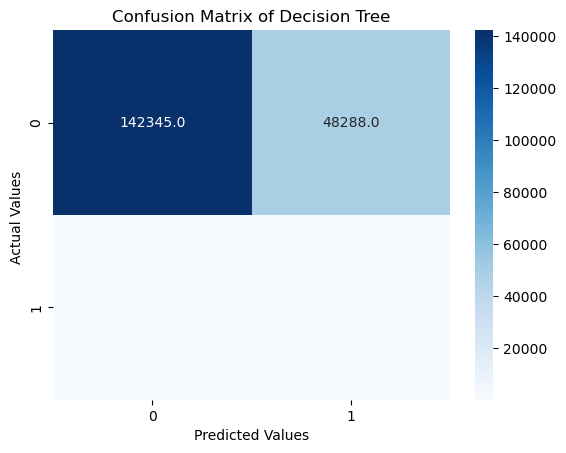

In [195]:
cm = confusion_matrix(y_test, y_pred)                      #------>Confusion Matrix
ax = sns.heatmap(cm, annot=True, cmap='Blues',fmt=".1f")     #------> Heatmap
ax.set_title('Confusion Matrix of Decision Tree')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

In [196]:
cm

array([[142345,  48288],
       [    10,    236]], dtype=int64)

## RandomForestClassifier

In [197]:
Rf_model = RandomForestClassifier(random_state=42)

In [198]:
Rf_model.fit(X_resampled, y_train)

C:\Users\kiran\AppData\Local\Temp\ipykernel_19500\3764275497.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  Rf_model.fit(X_resampled, y_train)


RandomForestClassifier(random_state=42)

In [199]:
# Validation
y_valid_Rf = Rf_model.predict(X_resampled)

In [200]:
metrics_df = calculate_metrics(y_train, y_valid_Rf, model=Rf_model, X_test=X_resampled)
metrics_df

,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,ROC AUC
Metrics,1.0,1.0,1.0,1.0,1.0,1.0


In [201]:
#Testing on unseen data
y_pred1 = Rf_model.predict(X_test)

In [202]:
metrics_df = calculate_metrics(y_test, y_pred1, model=Rf_model, X_test=X_test)
metrics_df

,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,ROC AUC
Metrics,0.91,1.0,0.91,0.95,0.94,0.99


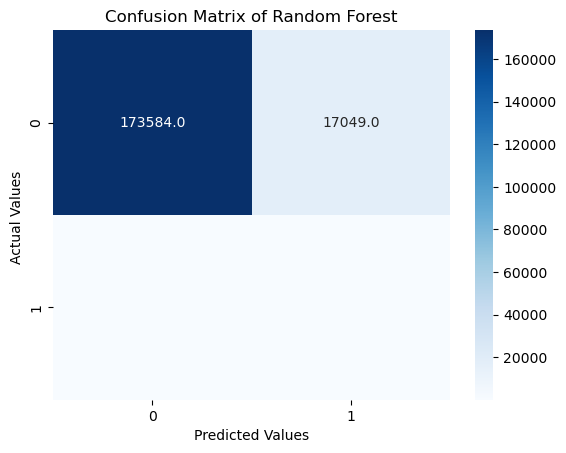

In [203]:
cm1 = confusion_matrix(y_test, y_pred1)                      #------>Confusion Matrix
ax = sns.heatmap(cm1, annot=True, cmap='Blues',fmt=".1f")     #------> Heatmap
ax.set_title('Confusion Matrix of Random Forest')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')
plt.show()


In [204]:
cm1


array([[173584,  17049],
       [     6,    240]], dtype=int64)

## XGBClassifier

In [205]:
Xg_model = XGBClassifier(random_state=42)

In [206]:
Xg_model.fit(X_resampled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [207]:
# Validation
y_valid_Rf = Rf_model.predict(X_resampled)

In [208]:
metrics_df = calculate_metrics(y_train, y_valid_Rf, model=Rf_model, X_test=X_resampled)
metrics_df

,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,ROC AUC
Metrics,1.0,1.0,1.0,1.0,1.0,1.0


In [209]:
# Testing on unseen data
y_pred2 = Xg_model.predict(X_test)

In [210]:
metrics_df = calculate_metrics(y_test, y_pred2, model = Xg_model, X_test=X_test)
metrics_df

,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,ROC AUC
Metrics,0.66,1.0,0.66,0.8,0.83,0.97


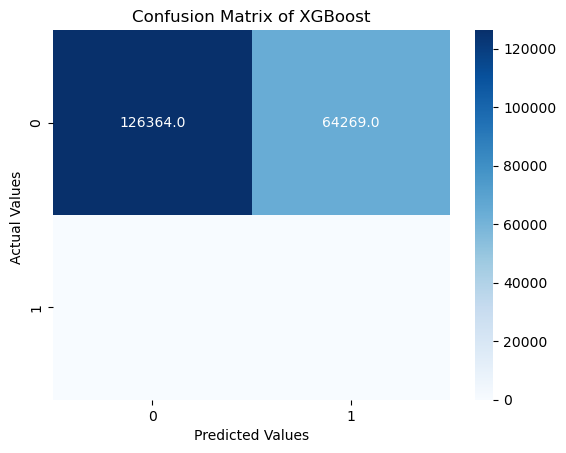

In [211]:
cm2 = confusion_matrix(y_test, y_pred2)                      #------>Confusion Matrix
ax = sns.heatmap(cm2, annot=True, cmap='Blues',fmt=".1f")     #------> Heatmap
ax.set_title('Confusion Matrix of XGBoost')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')
plt.show()


In [212]:
cm2

array([[126364,  64269],
       [     0,    246]], dtype=int64)

## LGBMClassifier

In [213]:
Lb_model = LGBMClassifier(random_state=42)

In [214]:
Lb_model.fit(X_resampled, y_train)

C:\Users\kiran\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kiran\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 100000, number of negative: 100000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2332
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(random_state=42)

In [215]:
# Validation
y_valid_Rf = Rf_model.predict(X_resampled)

In [216]:
metrics_df = calculate_metrics(y_train, y_valid_Rf, model=Rf_model, X_test=X_resampled)
metrics_df

,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,ROC AUC
Metrics,1.0,1.0,1.0,1.0,1.0,1.0


In [217]:
#Testing on unseen data
y_pred3 = Lb_model.predict(X_test)

In [218]:
metrics_df = calculate_metrics(y_test, y_pred3, model=Lb_model, X_test=X_test)
metrics_df

,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,ROC AUC
Metrics,0.82,1.0,0.82,0.9,0.91,0.99


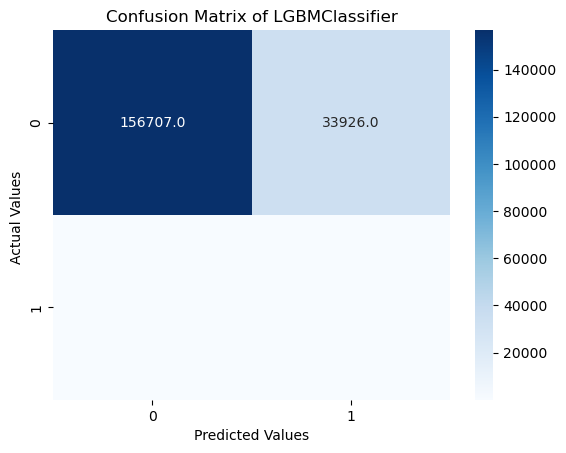

In [219]:
cm3 = confusion_matrix(y_test, y_pred3)                      #------>Confusion Matrix
ax = sns.heatmap(cm3, annot=True, cmap='Blues',fmt=".1f")     #------> Heatmap
ax.set_title('Confusion Matrix of LGBMClassifier')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

In [220]:
cm3

array([[156707,  33926],
       [     1,    245]], dtype=int64)

# Feature Importance

## Decision Tree

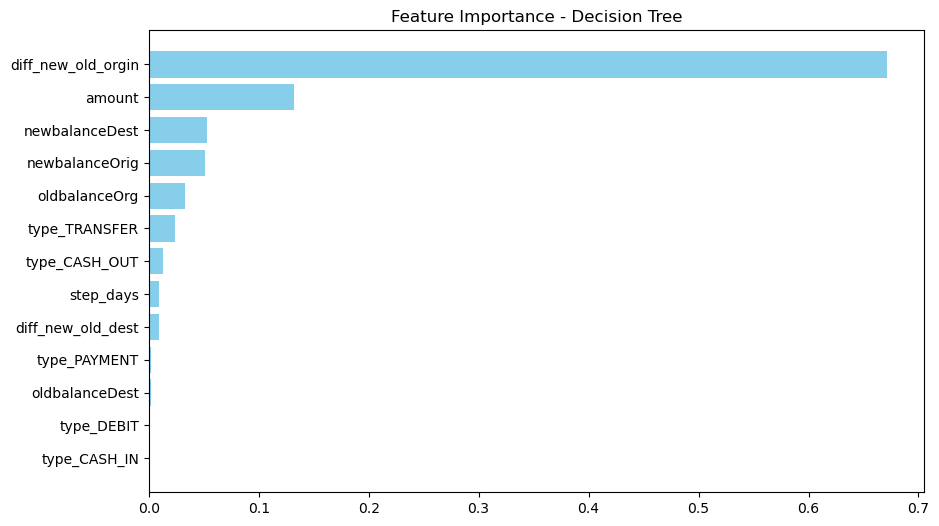

In [221]:
feature_names =  col
# Get Feature Importance
importances = Dtr_model.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title("Feature Importance - Decision Tree")
plt.gca().invert_yaxis()
plt.show()

## Random Forest

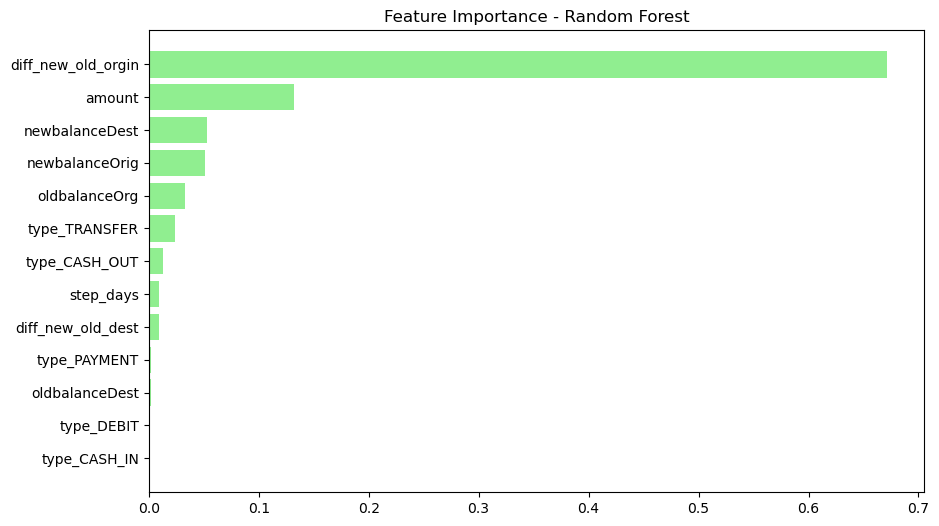

In [222]:
    # Get Feature Importance
    importances1 = Rf_model.feature_importances_
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot Feature Importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightgreen')
    plt.title("Feature Importance - Random Forest")
    plt.gca().invert_yaxis()
    plt.show()

## XGBoost

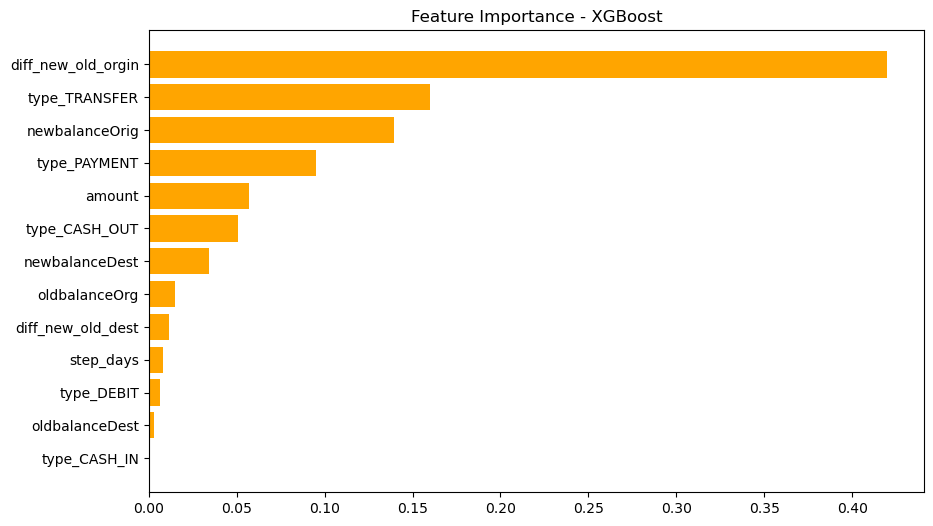

In [223]:
# Get Feature Importance
importances = Xg_model.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='orange')
plt.title("Feature Importance - XGBoost")
plt.gca().invert_yaxis()
plt.show()

## LightGBM

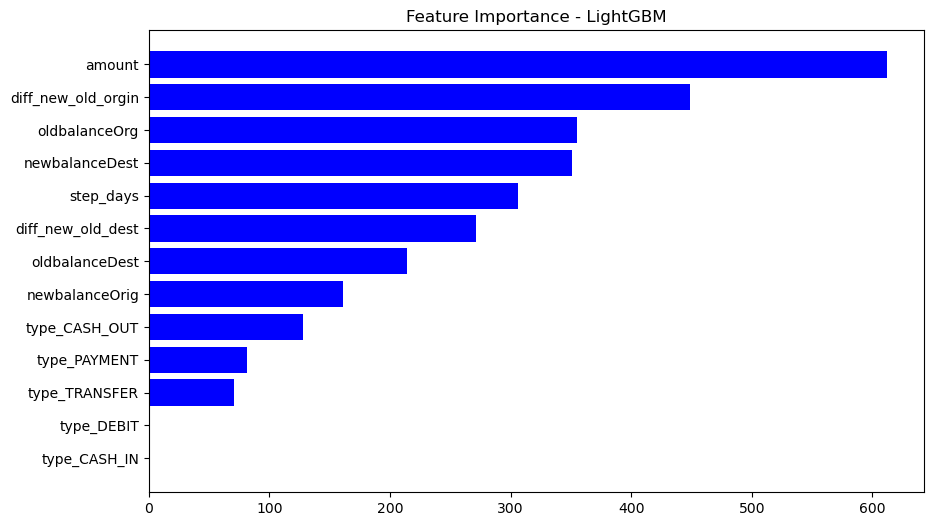

In [224]:
# Get Feature Importance
importances = Lb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue')
plt.title("Feature Importance - LightGBM")
plt.gca().invert_yaxis()
plt.show()

# Hyperparameter Tuning

## Random Forest

In [225]:
# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')


In [226]:
# Hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

In [227]:
# Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [228]:
# RandomizedSearchCV for Random Forest
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_grid,
    n_iter=50,
    scoring='f1',
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [229]:
# Fit the model
rf_random_search.fit(X_resampled, y_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\kiran\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='f1', verbose=2)

In [230]:
# Evaluate on the test set
best_rf_model = rf_random_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
y_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]


In [231]:
# Best parameters and cross-validation results
print("Best Parameters:", rf_random_search.best_params_)
cv_results = pd.DataFrame(rf_random_search.cv_results_)
print(cv_results[['mean_test_score', 'std_test_score', 'params']])

Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
    mean_test_score  std_test_score  \
0          0.994181        0.000129   
1          0.998347        0.000028   
2          0.994072        0.000075   
3          0.994127        0.000133   
4          0.998267        0.000063   
5          0.998347        0.000028   
6          0.994136        0.000026   
7          0.998147        0.000060   
8          0.994127        0.000133   
9          0.998242        0.000111   
10         0.998147        0.000051   
11         0.998112        0.000021   
12         0.994121        0.000070   
13         0.998052        0.000095   
14         0.994067        0.000007   
15         0.994136        0.000026   
16         0.998227        0.000067   
17         0.998362        0.000031   
18         0.998052        0.000095   
19         0.998227        0.000090   
20         0.998202        0.000012

In [282]:
metrics_df_rftuned = calculate_metrics(y_test, y_pred_rf, model= best_rf_model, X_test=X_test)
metrics_df_rftuned

,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,ROC AUC
Metrics,0.91,1.0,0.91,0.95,0.94,0.99


In [239]:
# Function to visualize metrics
def plot_metrics(y_test, y_proba_rf, y_pred_rf, model_name="Random Forest"):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba_rf)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()


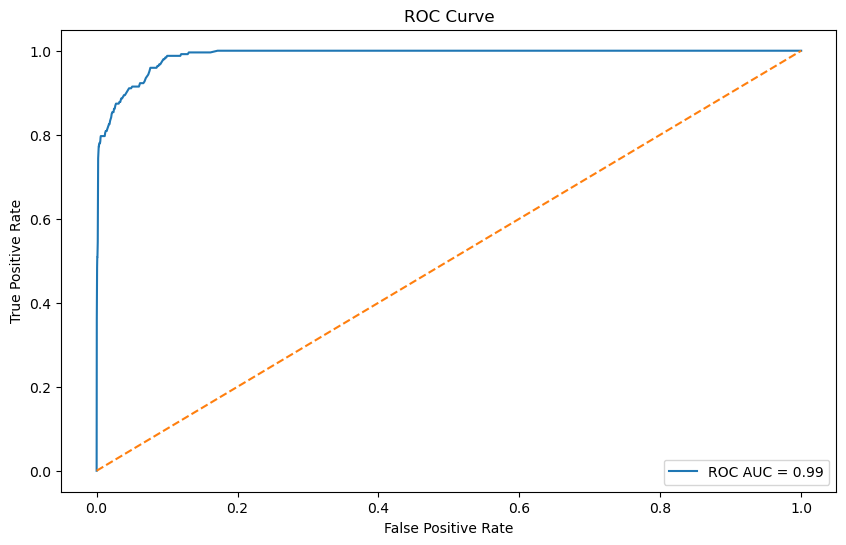

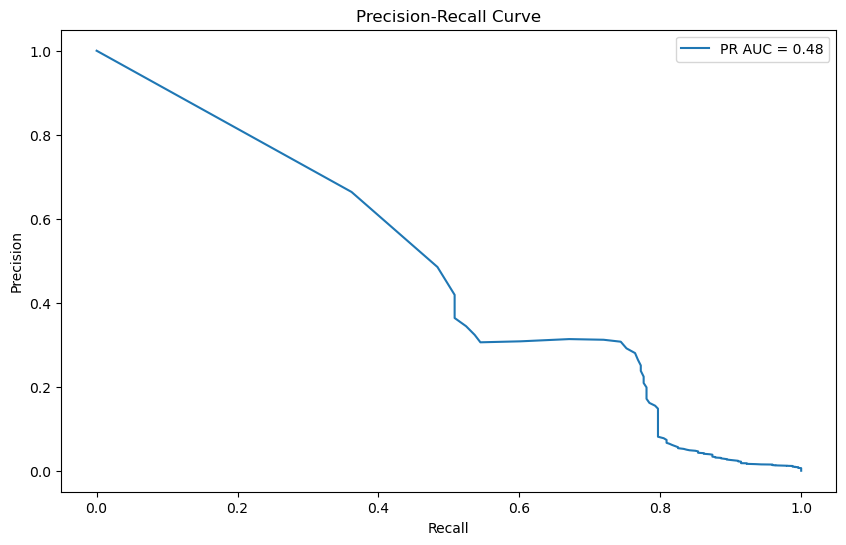

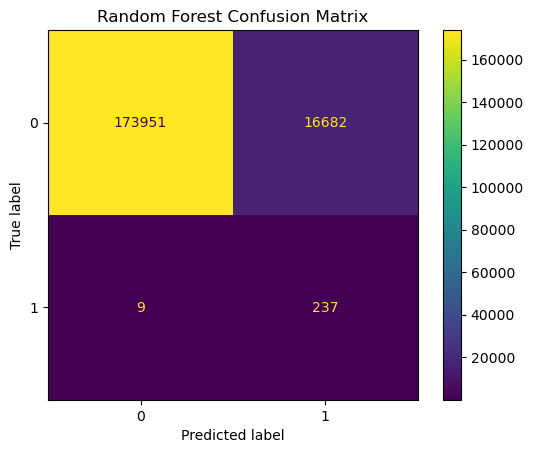

In [240]:
# Plot metrics for Random Forest
plot_metrics(y_test, y_proba_rf, y_pred_rf)

## XGBoost

In [263]:

# Define the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')


In [264]:
# Hyperparameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.1, 1.0, 10],
    'scale_pos_weight': [99]
}


In [265]:
# Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [266]:
# RandomizedSearchCV for XGBoost
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=50,
    scoring='f1',
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


In [267]:
# Fit the model
xgb_random_search.fit(X_resampled, y_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\kiran\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           imp...
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [50, 100, 200, 300],
                                        'reg_alpha': [0, 0.01, 0.1],
                                        'reg_lambda': [0.1, 1.0, 10],
                                        'scale_pos_weight': [99],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='f1', verbose=2)

In [268]:
# Best parameters and cross-validation results
print("Best Parameters:", xgb_random_search.best_params_)
cv_results = pd.DataFrame(xgb_random_search.cv_results_)
print(cv_results[['mean_test_score', 'std_test_score', 'params']])

Best Parameters: {'subsample': 0.6, 'scale_pos_weight': 99, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.6}
    mean_test_score  std_test_score  \
0          0.894250        0.000303   
1          0.979993        0.000390   
2          0.993108        0.000274   
3          0.978334        0.000389   
4          0.962551        0.000981   
5          0.988832        0.000815   
6          0.924371        0.000508   
7          0.994589        0.000309   
8          0.666671        0.000006   
9          0.994476        0.000383   
10         0.957552        0.001055   
11         0.985144        0.000469   
12         0.667187        0.000024   
13         0.989634        0.000588   
14         0.976076        0.000429   
15         0.894250        0.000303   
16         0.993784        0.000368   
17         0.993606        0.000325   
18         0.995327        0.000432   
19  

In [269]:
# Evaluate on the test set
best_xgb_model = xgb_random_search.best_estimator_
y_pred_xg = best_xgb_model.predict(X_test)
y_proba_xg = best_xgb_model.predict_proba(X_test)[:, 1]

In [270]:
# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_xg))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.64      0.78    190633
           1       0.00      1.00      0.01       246

    accuracy                           0.64    190879
   macro avg       0.50      0.82      0.39    190879
weighted avg       1.00      0.64      0.78    190879



In [281]:
metrics_df_xgtuned = calculate_metrics(y_test, y_pred_xg, model= best_xgb_model, X_test=X_test)
metrics_df_xgtuned

,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,ROC AUC
Metrics,0.64,1.0,0.64,0.78,0.82,0.98


In [271]:
# Function to visualize metrics
def plot_metrics(y_test, y_proba_xg, y_pred_xg, model_name="XGBoost"):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba_xg)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba_xg)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xg)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()


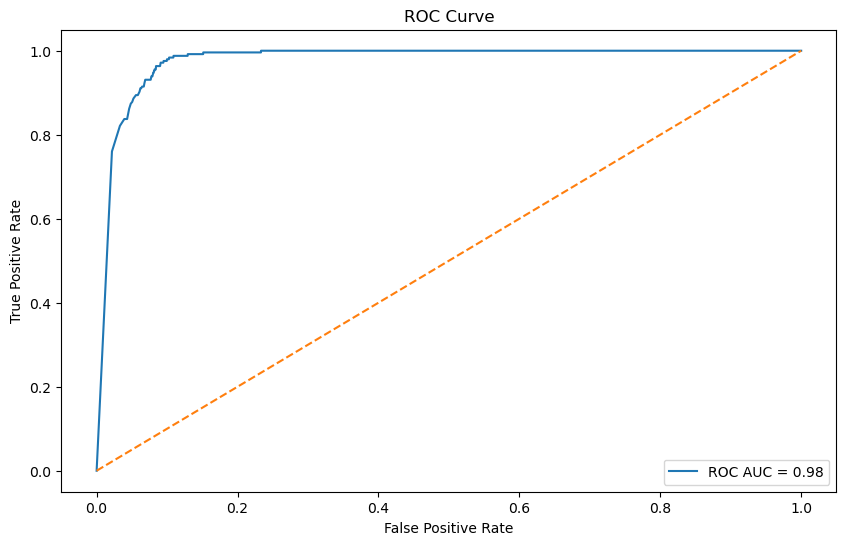

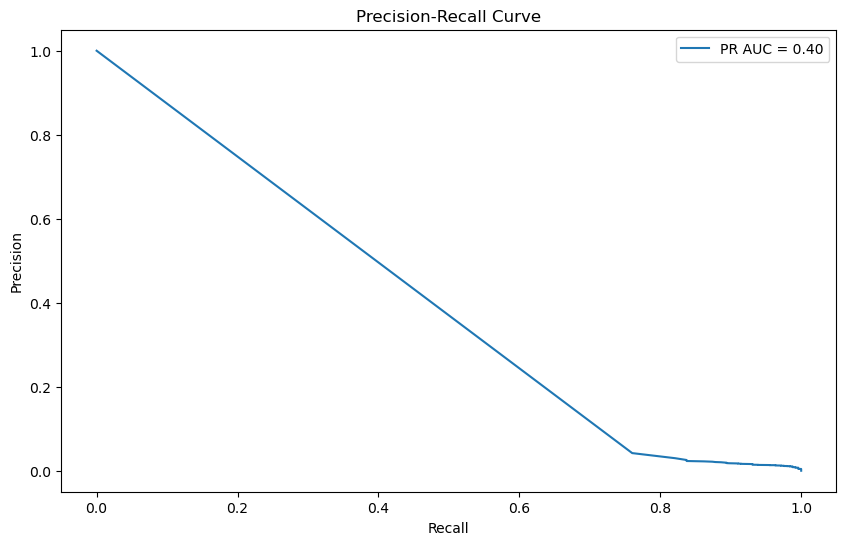

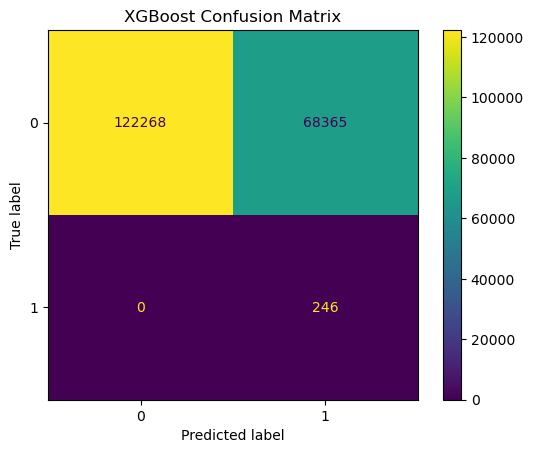

In [272]:
# Plot metrics for XGBoost
plot_metrics(y_test, y_proba_xg, y_pred_xg)

## LightGBM

In [253]:

# Define the LightGBM model
lgb_model = LGBMClassifier(random_state=42)


In [254]:
# Hyperparameter grid for LightGBM
lgb_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, -1],
    'num_leaves': [31, 50, 100, 200],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [99],  # Adjust for class imbalance
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.1, 1, 10]
}


In [255]:
# Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [256]:
# RandomizedSearchCV for LightGBM
lgb_random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=lgb_param_grid,
    n_iter=50,
    scoring='f1',
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [257]:
# Fit the model
lgb_random_search.fit(X_resampled, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\kiran\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\kiran\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 100000, number of negative: 100000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2332
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=LGBMClassifier(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, -1],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300, 500],
                                        'num_leaves': [31, 50, 100, 200],
                                        'reg_alpha': [0, 0.1, 0.5, 1],
                                        'reg_lambda': [0.1, 1, 10],
                                        'scale_pos_weight': [99],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='f1', verbose=2)

In [258]:
# Best parameters and cross-validation results
print("Best Parameters:", lgb_random_search.best_params_)
cv_results = pd.DataFrame(lgb_random_search.cv_results_)
print(cv_results[['mean_test_score', 'std_test_score', 'params']])


Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 99, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'num_leaves': 200, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
    mean_test_score  std_test_score  \
0          0.994975        0.000228   
1          0.894338        0.000402   
2          0.993064        0.000373   
3          0.997969        0.000051   
4          0.994851        0.000074   
5          0.997412        0.000097   
6          0.990334        0.000478   
7          0.996363        0.000320   
8          0.974430        0.000261   
9          0.997461        0.000118   
10         0.996438        0.000192   
11         0.995634        0.000225   
12         0.992822        0.000198   
13         0.894338        0.000402   
14         0.981257        0.000484   
15         0.969813        0.000876   
16         0.990551        0.000690   
17         0.990850        0.000410   
18         0.983337        0.000499 

In [259]:
# Evaluate on the test set
best_lgb_model = lgb_random_search.best_estimator_
y_pred_lgb = best_lgb_model.predict(X_test)
y_proba_lgb = best_lgb_model.predict_proba(X_test)[:, 1]


In [280]:
metrics_df_lgbtuned = calculate_metrics(y_test, y_pred_lgb, model= best_lgb_model, X_test=X_test)
metrics_df_lgbtuned

,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,ROC AUC
Metrics,0.67,1.0,0.67,0.8,0.83,0.98


In [261]:

# Function to visualize metrics
def plot_metrics(y_test, y_proba_lgb, y_pred_lgb, model_name="LightGBM"):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba_lgb)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba_lgb)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()
     # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lgb)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()


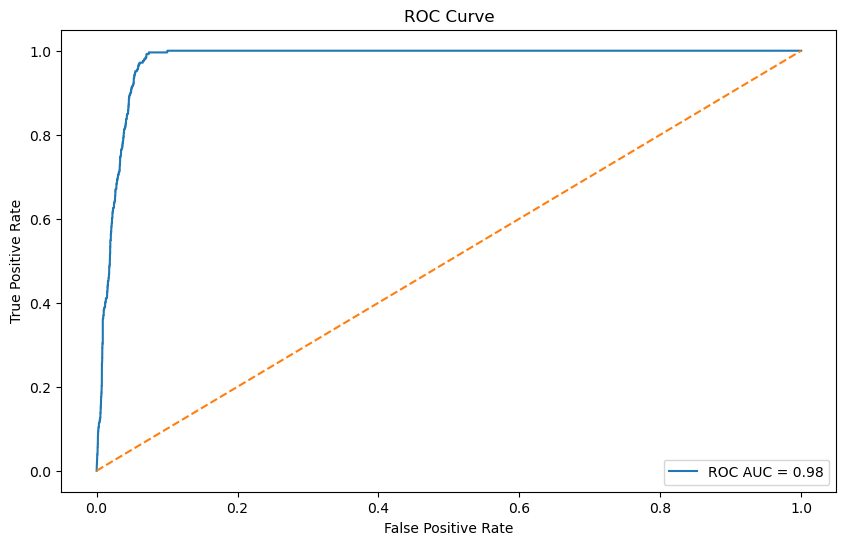

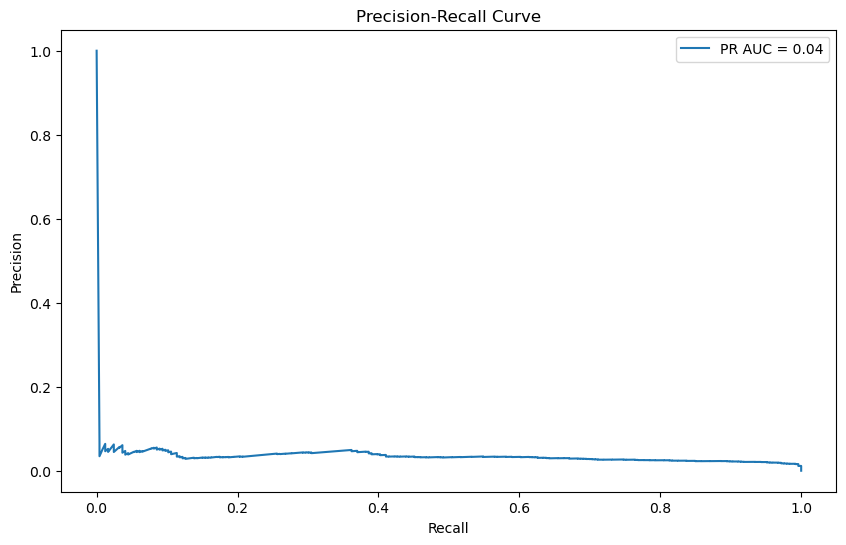

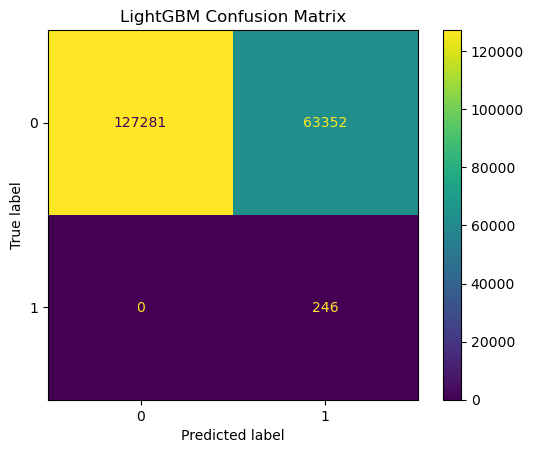

In [262]:
  
# Plot metrics for LightGBM
plot_metrics(y_test, y_proba_lgb, y_pred_lgb)

# Pickle

In [283]:
encoder_file_1 = 'encoder_1.pkl'
scaler_file_1 = 'scaler_1.pkl'
model_file_rf = 'final_model_rf.pkl'

In [284]:
with open(encoder_file_1, 'wb') as f:
    pickle.dump(one_hot_enc, f)

In [285]:
with open(scaler_file_1, 'wb') as f:
    pickle.dump(scaler, f)

In [286]:
with open(model_file_rf, 'wb') as f:
    pickle.dump(best_rf_model, f)